In [212]:
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import sys
from scipy.integrate import quad
from scipy.optimize import newton

def findChi2CL(cl,df):
    def rightCDF(x2,df,target=None):
        if target is None:
            return quad(stats.chi2.pdf,x2,np.inf,args=(df,))[0]
        else:
            return quad(stats.chi2.pdf,x2,np.inf,args=(df,))[0] - target
    return newton(rightCDF,df,args=(df,cl))

## What is a $\chi^2$ distribution?

Before we talk about $\chi^2$ tests we need to discuss the eponymous distribution it is based upon. If I want to test how well a model fits some data, the question I am really asking is: what is the chance that the model only works by coincidence? How would I test this? Well, if I have $N$ data points, I could compare my model's performance, at the $N$ points, to a random distribution with $N$ degrees of freedom. 

First, I need to decide what to compare. The simplest case is just the "distance" between the model and the data, i.e. $\propto (E - O)^2$, where $O$ is the data value and $E$ the predicted value. I don't want the comparator to have physical units (to ensure it works in any scenario). Therefore, I will define the distance between my model and the data at $x$ via
\begin{equation}
d^2 = \left(\frac{E(x) - O(x)}{\delta(x)}\right)^2 \; ,
\end{equation}
this $\delta(x)$ can be chosen several ways to produce different tests. If we know the uncertainties on our measurements $O$ then $\delta = \delta O$, otherwise we can just use either $O$ or $E$ (I prefer using $O$). 

This isn't quite enough yet. How do I deal with multiple data points? I can just sum them, of course! This now defines our $\chi^2$ value
\begin{equation}
\chi^2 = \sum_i^N \left(\frac{E(x_i) - O(x_i)}{\delta(x_i)}\right)^2 \; .
\end{equation}

So, now I know what the comparator is, its the sum of the of N squares. Thus, my random version can be the sum of the squares of N randomly generated numbers. The distribution for this is the $\chi^2$ distribution with $N$ degrees of freedom. There's a caveat though, $\chi^2$ is a distribution for $N$ **independent** random variables. This means it will only be accurate if our measurements at each data point are uncorrelated. Most of the time we can assume this, but often instruments like telescopes do have correlations. 

For instance, a gamma-ray telescope categorises photons into energy bins. This means it considers all photons in the range $E_{n}$ to $E_{n+1}$, bin $n$, as having the same energy. Instruments are never 100\% accurate, so photons can be misclassified. This means they can end up in either bin $n-1$ or $n+1$ instead of $n$. Thus the bin $n$ can become correlated with its neighbours, the correlation being defined by the accuracy of the instrument in classifying photon energies.

For now we will neglect the possibility of correlated data and merrily continue with independent data points. First, we can take a look at the $\chi^2$ distribution itself. Probability distributions have two important forms to consider: the probability density and cumulative density. The probability density (pdf) is the probability that a variable takes a value between $x$ and $x+dx$ per unit $x$. The cumulative distribution (cdf) is the probability that a variable is smaller than $x$, its thus an integral over the pdf from $-\infty$ to $x$. 

Let's generate a pdf and a cdf for $\chi^2$, we will assume that we have $N=20$ data points. To do this I need to use the scipy.stats package (imported above). scipy.stats.chi2 provides access to all of the properties I need. Note that each method requires I specify the degrees of freedom as well as the values of $\chi^2$ (remember the distribution is assigning probabilities to values of $\chi^2$). 

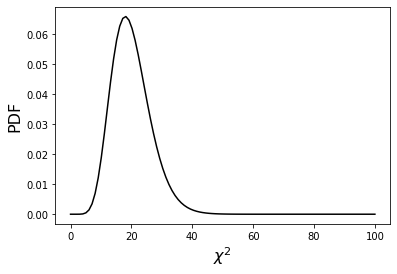

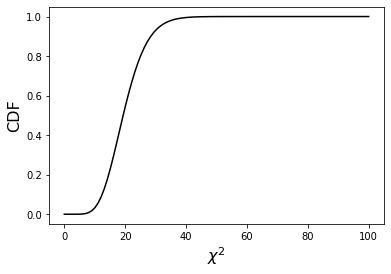

In [213]:
N = 20
x = np.linspace(0, 100,num=100)
plt.plot(x,stats.chi2.pdf(x,N),label="PDF",color="k",linestyle="-")
plt.xlabel(r"$\chi^2$",fontsize=16); plt.ylabel("PDF",fontsize=16)
plt.show()

plt.plot(x,stats.chi2.cdf(x,N),label="CDF",color="k",linestyle="-")
plt.xlabel(r"$\chi^2$",fontsize=16); plt.ylabel("CDF",fontsize=16)
plt.show()

From my pdf I can see that the distribution has two tails, or two regions where the pdf becomes vanishingly small. The cdf and pdf are only defined for $\chi^2 > 0$ which makes sense when you think about it. Additionally, as expected, the cdf rises from 0 towards 1 as $\chi^2$ gets larger. It is the probability that $\chi^2 < x$ after all. 

## How does this help us?

We know the probability that a set of random numbers will generate various sums of squares. This means we can compare the distance between our model and the data to this. What does this achieve? It tells us how likely any match between our model and data is down to pure chance. To make this comparison we will use the cdf. Sometimes people use the "survival function", or sf, which is 1 - cdf (consistency is key).

The cdf is small at small values of $\chi^2$. We can interpret this as meaning that, for a very good match between $O$'s and $E$'s, the probability of the relationship being a statistical fluke is very small. In practice we use several thresholds for this. These are called confidence levels and are often referred to as $\sigma$'s, i.e. $1\sigma$ is a confidence level of $\sim 68\%$, $2\sigma$ is $95\%$, and $3\sigma$ is $99.99\%$. The percentages represent our confidence that the model is accurately predicting the data. Where do these levels come from? Simply put these are integrals over a normal distribution. The scheme is for the ith C.L. 
\begin{equation}
P_{CL}(i) = \int_{-i}^{i} dx \, \frac{\mathrm{e}^{-\frac{x^2}{2}}}{\sqrt{2\pi}} \; .
\end{equation}
The normal distribution is used here as it corresponds to a model of normally distributed errors (under assumptions like central limit theorem). You can see that, since $\sigma = 1$, we are integrating from $-i\sigma$ to $i\sigma$. The choice of mean and variance are irrelevant, these results will always be true for a normal distribution.

## Exclusion by data

Here is where we use data to say that some models must be rejected at a given confidence level, because they make the wrong predictions. Note that whether we care about under or over-predicting data depends on our scenario. For dark matter hunting, we can only place limits on models that produce more emissions than actually observed (if it were less, these models could just be hidden under the stronger signal). Thus, we only care about over-predictions by the model. 

For a large number of data points the central limit and Wilks' theorems hold and $\Delta \chi^2 = \chi^2 - \mathrm{min}(\chi^2)$ can be treated as a random $\chi^2$-distributed (1 degree of freedom per free parameter) variable with a CDF being given by
\begin{equation}
P (\chi^2) =  \int_{\chi}^{\infty} dx \, \frac{\mathrm{e}^{-\frac{x^2}{2}}}{\sqrt{2\pi}} \; .
\end{equation}
We can then find a 95\% probability of exclusion by solving
\begin{equation}
0.05 = \int_{\chi_c}^{\infty} d\chi \, \frac{\mathrm{e}^{-\frac{\chi^2}{2}}}{\sqrt{2\pi}} \; ,
\end{equation}
for $\chi_c$. We are essentially searching for models that only have a 5\% chance of explaining our data. This integral is relatively simple (given by the [gaussian error function](https://en.wikipedia.org/wiki/Error_function)). You can verify for yourself that if $\chi_c \approx \sqrt{2.71}$ we satisfy the above equation. In other words, to make a 95\% exclusion we must find the model that has a $\Delta \chi^2 = 2.71$. This process is known as a one-sided $\chi^2$ test.

In some cases we can't treat $\chi^2$ this way (i.e. not a large number of data points). In these cases we need to do a normal $\chi^2$ test. Here we need find a model that has a one-sided CDF = 0.95, where we use the exact $\chi^2$ PDF in the same way we used the guassian PDF above but we also use $\chi^2$ instead of $\Delta \chi^2$. In practice we might need to do this for cases where we have fewer than 50 degrees of freedom (data points - free parameters). To do this for a one-sided test I have provided a method `findChi2CL` which when given the confidence level, i.e. 0.95, and the number of degrees of freedom (data points - free parameters) finds the required $\chi^2$ value for the exclusion. Be warned, however, the statistical significance of exclusions from small sets of data is questionable. 

### A note on likelihoods

Our $\chi^2$ renormalisation wasn't just a thumb-suck. In fact it corresponds to performing a so-called "likelihood ratio test". Where our likelihood is
\begin{equation}
\mathcal{L}_i = \mathrm{e}^{-\chi_i^2/2} \; ,
\end{equation}
for model $i$ and our ratio test is done via
\begin{equation}
2\ln{\left(\frac{\mathcal{L}_i}{\mathcal{L}_{\mathrm{max}}}\right)} = \chi^2_i - \chi^2_{\mathrm{min}} \; .
\end{equation}

Wilk's theorem says that as the number of samples $\to \infty$, our likelihood ratio itself is $\chi^2$ distributed (regardless of $\mathcal{L}$) with degrees of freedom equal to the number of free parameters. This means we can achieve a similar result if we `findChi2CL(0.95,n)` as the required $\Delta \chi^2$ value (`n` is the number of free parameters). 


## Example

Below I will set up a model and implement these ideas

In [214]:
def modelResult(x,A):
    mu = 5e1
    sig = 1e1
    #artificial model I created 
    return 1e-12*np.exp(-(x-mu)**2/sig**2*0.5)*A

def dataResult(x,y0,alpha):
    #fake data that's just a power-law
    return y0*x**alpha

My model has 1 free parameter, the amplitude `A`.

I will now choose some x range to consider, I want the gaussian bump of the model to fit into the range so I take

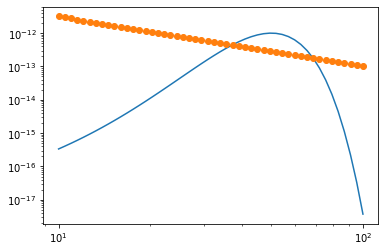

In [215]:
x = np.logspace(1,2,num=50)
model = modelResult(x,1.0)
data = dataResult(x,1e-10,-1.5)
plt.plot(x,model)
plt.yscale("log");plt.xscale("log")
plt.plot(x,data,linestyle="none",marker="o")
plt.show()

Now we can link this to a dark matter scenario by noting that our dark matter free parameter is  $\langle \sigma V \rangle$ which acts just like $A$! We want to find which values of $\langle \sigma V \rangle$ (or $A$) that are excluded by the data at 95\% confidence level. Therefore we must consider the model results for a range of cross-sections. By doing so, we hope to exclude values of the cross-section that over-predict the data. Note that I set up the model function here so that $\langle \sigma V \rangle = A \times 10^{-26}$ cm $^3$ s $^{-1}$. 

In [216]:
aVals = np.logspace(-3,3,num=3000)
model = np.tensordot(aVals,model,axes=0)

What I have done here is generated a 2D array where each element is every possible combination of cross-section values times a model value. I will need to ensure my data is the same shape array (to be able to compare them). However, data does not vary with aVals, it is fixed. Thus, I will do the following

In [217]:
data = np.tensordot(np.ones_like(aVals),data,axes=0)

Which generates a 2D array filled with copies of data array. Now I can find their $\chi^2$ values

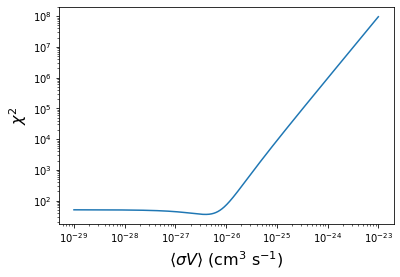

In [218]:
def chiSquare(model,data,axis=-1,dataUncert=None,alpha=2):
    """
    model and data are the predicted and observed values respectively
    This method assumes data and model are sampled at the same values of the independent variable
    """
    if dataUncert is None:
        dataUncert = data #modify the test if we don't know the uncertainties on the data
    if dataUncert.shape != data.shape or model.shape != data.shape:
        print("chiSquare error: model, data, and dataUncert (if specified) must be the same shape!")
        sys.exit(2)
    return np.sum((model-data)**alpha/dataUncert**alpha,axis=axis) #we always sum over the data points so I need to specify which axis this corresponds to

chi2 = chiSquare(model,data,axis=-1)

plt.plot(aVals*1e-26,chi2)
plt.ylabel(r"$\chi^2$",fontsize=16)
plt.xlabel(r"$\langle \sigma V\rangle$ (cm$^3$ s$^{-1}$)",fontsize=16)
plt.yscale("log");plt.xscale("log")
plt.show()

Note my use of the argument "axis=-1", this is because I multiplied data by a set of ones on the left. Thus, the data axis is the last axis (or -1). All I now need to do is find which $\langle \sigma V \rangle$ leads to $\Delta \chi^2 = 2.71$.  I can plot this graphically as

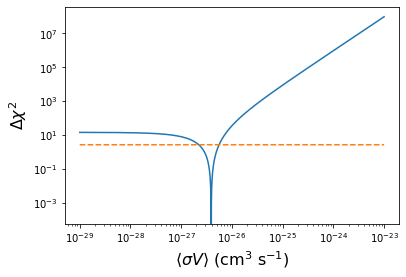

In [219]:
dchi2 = chi2 - np.min(chi2)

plt.plot(aVals*1e-26,dchi2)
plt.plot(aVals*1e-26,np.ones_like(aVals)*2.71,linestyle="--")
plt.ylabel(r"$\Delta\chi^2$",fontsize=16)
plt.xlabel(r"$\langle \sigma V\rangle$ (cm$^3$ s$^{-1}$)",fontsize=16)
plt.yscale("log");plt.xscale("log")
plt.show()

Which shows I have an issue. There are two values of $\langle \sigma V \rangle$ that have $\Delta \chi^2 = 2.71$! Recall, however, that we want the case that **over-predicts** the data. We know that the model is $\propto \langle \sigma V \rangle$, thus over-prediction implies larger $\langle \sigma V \rangle$. Thus, we only need consider $\langle \sigma V \rangle$ values that are larger than the best-fit. 

I will implement this as follows

In [220]:
mIndex = dchi2.argmin()
overSigV = aVals[mIndex+1:]
overDChi2 = dchi2[mIndex+1:]
intp = interp1d(overDChi2,overSigV)
clChi2 = findChi2CL(0.05,1) #1 degree of freedom because there is 1 free parameter
exSigV = intp(2.71)*1e-26
print(f"Our central-limit exclusion is for cross-sections > {intp(2.71)*1e-26} cm^3 s^-1")
print(f"The full chi^2 distribution one-sided CDF yields cross-sections > {intp(clChi2)*1e-26} cm^3 s^-1")

0.957607014657061
Our central-limit exclusion is for cross-sections > 5.579622225126661e-27 cm^3 s^-1
The full chi^2 distribution one-sided CDF yields cross-sections > 5.899560885672455e-27 cm^3 s^-1


So we know know that $\langle \sigma V \rangle > 5.6 \times 10^{-27} \ \mathrm{cm}^3 \ \mathrm{s}^{-1}$  are excluded at 95\% confidence interval. The value from he full $\chi^2$ CDF is quite similar (showing our central limit case is working). 

Let's now do some sanity checks. First we can confirm the upper-limit lies at the right value of $\Delta \chi^2$

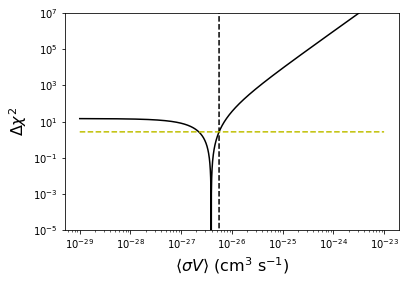

In [221]:
plt.plot(aVals*1e-26,dchi2,color="k")
plt.plot(np.ones_like(aVals)*exSigV,np.linspace(0,max(dchi2),num=len(aVals)),linestyle="--",color="k")
plt.plot(aVals*1e-26,np.ones_like(aVals)*2.71,linestyle="--",color="y")
plt.xscale("log");plt.yscale("log")
plt.ylim([1e-5,1e7])
plt.ylabel(r"$\Delta \chi^2$",fontsize=16)
plt.xlabel(r"$\langle \sigma V\rangle$ (cm$^3$ s$^{-1}$)",fontsize=16)
plt.show()


We can see our excluded value sits exactly at $\Delta\chi^2 = 2.71$. Second, we will plot a comparison of our data with this model prediction

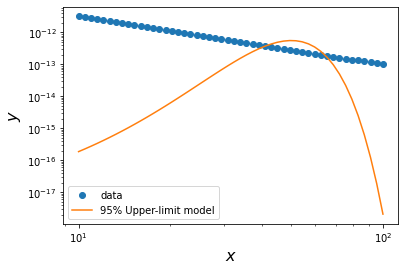

In [222]:
plt.plot(x,dataResult(x,1e-10,-1.5),label="data",linestyle="none",marker="o")
plt.plot(x,modelResult(x,1.0)*exSigV/1e-26,label="95% Upper-limit model")
plt.ylabel(r"$y$",fontsize=16)
plt.xlabel(r"$x$",fontsize=16)
plt.yscale("log");plt.xscale("log")
plt.legend()
plt.show()

Our second sanity check is good, as our upper-limit model is exceeding the data at several data points (if it was very few we would have questionable significance for our exclusion). 

## Incorporating dark matter mass

The above example works for a fixed dark matter mass. I will now modify the model to include a fake version of the effect of varying the mass. Due to my choice of model, I will need to expand the x range as well.

In [223]:
def modelResultMass(x,m):
    mu = 5e1*m/10.0
    sig = 1e1*m/10
    #artificial model I created 
    return 1e-12*np.exp(-(x-mu)**2/sig**2*0.5)/(m/10)**2

def dataResult(x,y0,alpha):
    #fake data that's just a power-law
    return y0*x**alpha

Now what I aim to do is find a sigV limit for a set of masses. I will choose a few and run a loop over them

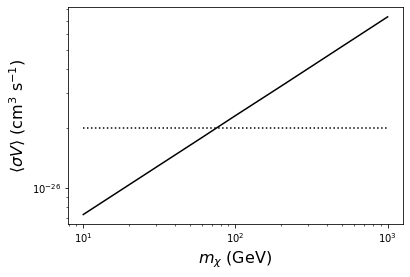

In [224]:
mSet = [1e1,2e1,4e1,6e1,8e1,1e2,2e2,3e2,5e2,1e3]
upperLims = []

for m in mSet:
    x = np.logspace(0,5,num=60)
    model = modelResultMass(x,m)
    data = dataResult(x,1e-10,-1.5)
    aVals = np.logspace(-3,3,num=3000)
    model = np.tensordot(aVals,model,axes=0)
    data = np.tensordot(np.ones_like(aVals),data,axes=0)
    mChi2 = chiSquare(model,data,axis=-1,alpha=2)
    chiDiff = mChi2 - np.min(mChi2)
    mIndex = chiDiff.argmin()
    mIntp = interp1d(chiDiff[mIndex+1:],aVals[mIndex+1:])
    upperLims.append(mIntp(2.71)*1e-26)

plt.plot(mSet,upperLims,linestyle="-",color="k")
plt.plot(mSet,np.ones_like(mSet)*2e-26,linestyle=":",color="k")
plt.yscale("log");plt.xscale("log")
plt.ylabel(r"$\langle \sigma V\rangle$ (cm$^3$ s$^{-1}$)",fontsize=16)
plt.xlabel(r"$m_\chi$ (GeV)",fontsize=16)
plt.show()

My final plot is then the exclusion curve, models above the solid line are excluded at 95% C.L. The dotted line is the thermal relic cross-section (the value needed to produce the amount of observed dark matter )

## What happens if the data is 2D?

In this case very little changes, our algorithm above is robust to the dimensions of our data. One difference would be we need to sum over both data axes, in `np.sum` this can be done by specifying a tuple of all the axes to sum over, i.e. `np.sum(stuff,axis=(-1,-2))` will sum over the last and second-last axes of `stuff`.